In [9]:
import torch
import gym
import matplotlib.pyplot as plt
from IPython import display

In [10]:
torch.cuda.is_available()

True

In [11]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

In [12]:
env.observation_space.shape

(4,)

In [13]:
env.action_space

Discrete(2)

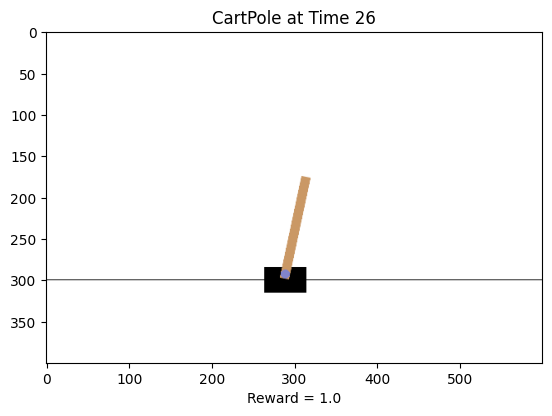

In [14]:
env.reset()
reward=0

fig, ax = plt.subplots()

for i in range(300):
    
    #plotting code
    ax.imshow(env.render())
    ax.set_title(f"CartPole at Time {i}")
    ax.set_xlabel(f"Reward = {reward}")
    display.display(plt.gcf())    
    display.clear_output(wait=True)
    
    # Step through environment using chosen action
    action = env.action_space.sample() #sample an action randomly
    state, reward, done, truncated, info = env.step(action)
    if done:
        break

In [15]:
env = gym.make('ALE/Pong-v5', render_mode="rgb_array") #may need to run pip install "gym[accept-rom-license, atari]” in terminal to make this work

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [16]:
env.observation_space.shape

(210, 160, 3)

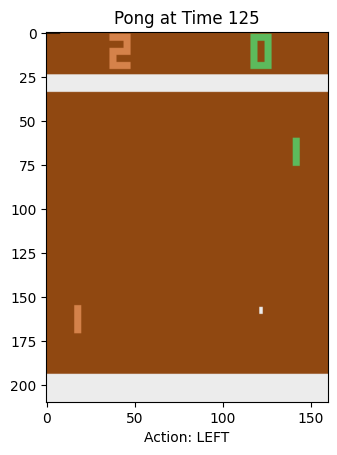

In [ ]:
env.reset()
rewards = []
action = 0
possible_actions = ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

fig, ax = plt.subplots()

for i in range(200):
    ax.clear()
    ax.imshow(env.render())
    ax.set_title(f"Pong at Time {i}")
    ax.set_xlabel(f"Action: {possible_actions[action]}")
    display.display(plt.gcf())    
    display.clear_output(wait=True)
    
    # Step through environment using chosen action
    action = env.action_space.sample() #sample an action randomly
    state, reward, done, truncated, info = env.step(action)
    
    rewards.append(reward)
    if done:
        break